# Feature Consistency Analysis for Model selection

In this exercise, you will implement feature consistency analysis for model selection. For this task we've generated data from ramping dynamics, split it into two data samples, and optimized a model potential on each of the datasamples for 10,000 iterations. You will upload the optimization results for two datasamples and perform feature consistency analsys in order to select the correct model.

To perform FC analysis, we will use the following method:
    
    FeatureConsistencyAnalysis(data1, data2, em, iteration_indices, FC_stride)
     """ Calculate JS divergence and feature complexities for two sequences of models data1 and data2.
    

    Parameters
    ----------
    data1 : dictionary
        Dictionary with peqs fitted on datasample 1 (the 1st sequence of fitted models).
    data2 : dictionary
        Dictionary with peqs fitted on datasample 2 (the second sequence of fitted models).
    em : EnergyModel
        An instance of energymodel class used for fitting (that contains the common D, p0, and fr functions).
    iteration_indices : numpy array
        Indices of peqs which will be used for the analsys (to accelerate the computation, one may only consider 
        the models at a subset of iterations, rather then all models at each iteration).
    FC_stride : int
        This parameter determines how many models from the sequence 2 will be compared with the model from 
        the sequence 1 at each level of feature complexity. The number of comparison at each level of 
        feature complexity is 2*FC_stride+1.

    Returns
    -------
    FC : numpy array
        Feature complexities.
    JS : numpy array
        JS divergences between the two models at each level of feature complexity.
    min_inds1 : numpy array
        Indices of the models at each level of feature complexity in data1 array.
    min_inds2 : numpy array
        Indices of the models at each level of feature complexity in data2 array.

    """

In [ ]:
# Package installation - needed to run in google Collab. Comment this is you run the code locally 
!pip install git+https://github.com/engellab/neuralflow
!mkdir data
import urllib.request
urllib.request.urlretrieve('https://github.com/engellab/neuralflow/raw/master/tutorials/CCN2021/data/Part5_datasample1.pkl', "data/Part5_datasample1.pkl")
urllib.request.urlretrieve('https://github.com/engellab/neuralflow/raw/master/tutorials/CCN2021/data/Part5_datasample2.pkl', "data/Part5_datasample2.pkl")

In [1]:
import neuralflow
from neuralflow.utilities.FC_nonstationary import FeatureConsistencyAnalysis, FeatureComplexity
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import pickle

In [2]:
# Cell 1: upload the data, initialize EnergyModel class variable for model selection.

EnergyModelParams = {'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111, 
               'peq_model':{'model': 'uniform', 'params': {}},
               'p0_model': {'model': 'single_well', 'params': {'miu': 200, 'xmin': -0.3}},
               'D0': 0.1,
               'boundary_mode':'absorbing',
               'num_neuron':1,
               'firing_model':[{'model': 'linear','params': {'r_slope': 50, 'r_bias': 60}}],
               'verbose':True
               }

# An instance of EnergyModel class that will be used for FC analysis. Note that here we set peq to uniform to pretend
# that we do not know the correct model
em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

# Load the optimization results
with open ("data/Part5_datasample1.pkl","rb") as fp:
    data1 = pickle.load(fp)
with open ("data/Part5_datasample2.pkl","rb") as fp:
    data2 = pickle.load(fp)

# Also initialize the ground-truth model for visual comparison
peq_gt = neuralflow.peq_models.linear_pot(em_fitting.x_d_,em_fitting.w_d_,slope=-5)

Before performing model selection, let us visualize the models optimized on data sample 1.

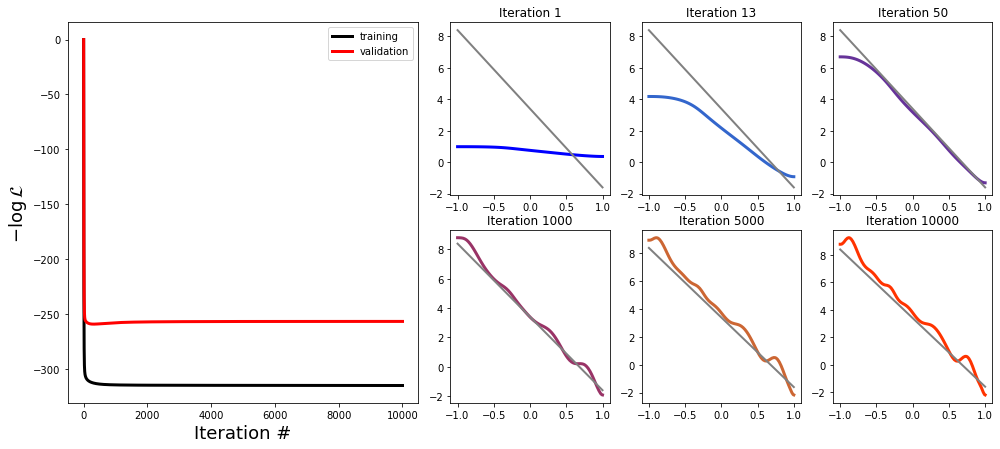

In [3]:
# Cell 2. Visualize optimization results from data sample 1.

lls=data1['logliks']
lls_CV=data1['logliksCV']

#Shift training and validated loglikelihoods such that they both start from 0 for visualisation purposes
lls= (lls-lls[0])
lls_CV=(lls_CV-lls_CV[0])

fig=plt.figure(figsize=(20,7))
gridspec.GridSpec(2,6)

Iterations =[1,13,50,1000,5000,10000]
Iterations_indices = np.argmin(np.abs(np.subtract.outer(data1['iter_num'],Iterations)),axis=0)

colors=[[0.0, 0.0, 1.0],
        [0.2, 0.4, 0.8],
        [0.4, 0.2, 0.6],
        [0.6, 0.2, 0.4],
        [0.8, 0.4, 0.2],
        [1.0, 0.2, 0.0]]

# Plot negative loglikelihood vs. iteration number
plt.subplot2grid((2,6), (0,0), colspan=2, rowspan=2)

# Training negative loglikelihood
plt.plot(np.arange(1,lls.size+1),lls,color='black',linewidth=3,label='training')
# Validation negative loglikelihood
plt.plot(np.arange(1,lls_CV.size+1),lls_CV,color='red',linewidth=3, label='validation')
plt.xlabel('Iteration #', fontsize=18)
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)
plt.legend()

#Plot potentials. Potential is calculated from peq by taking negative log: Phi = - log(peq). 
for i,Iter in enumerate(Iterations):
    plt.subplot2grid((2,6), (i//3,2+i%3))
    plt.plot(em_fitting.x_d_,-np.log(data1['peqs'][...,Iterations_indices[i]]),color=colors[i],linewidth=3)
    plt.plot(em_fitting.x_d_,-np.log(peq_gt),color='grey',linewidth=2)
    plt.title(f'Iteration {Iter}') 

Now calculate JS divergence at each level of feature complexity.

In [9]:
# Cell 3

# This parameter will determine how many models from sequence 2 are compared with a model from sequence 1 for each 
# level of feature complexity
FC_stride = 10

# First, select a subset of models that will be used for feature consistency analysis
number_of_models = 100
iterations_selected=np.unique(np.concatenate((np.array([0]),np.logspace(0,4,number_of_models))).astype(int))

# Find the indices of the selected iterations in the data1/data2 arrays
iteration_indices = np.argmin(np.abs(np.subtract.outer(data1['iter_num'],iterations_selected)),axis=0)

# Find JS divergence for each level of feature complexity
FCs_array1, JS, inds1, inds2 = FeatureConsistencyAnalysis(data1, data2, em_fitting, iteration_indices, FC_stride)

Visualize the results with interactive plotly graph.

In [10]:
# Cell 4

import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots

JS_thres=0.001

# FC_cur - is the current feature complexity
FC = FCs_array1.min()

# Create figure
fig = make_subplots(rows=2, cols=1,vertical_spacing=0.1)
fig.update_layout(width=1000,height=800)

# JSD(FC) curve - static plot
fig.add_trace(
    go.Scatter(
        visible=False,
        line=dict(color="#00CED1", width=3),
        name=r'${\rm JSD}(\mathcal{M})$',
        x=FCs_array1,
        y=JS),
        row = 1,
        col = 1)
# Threshold JSD
fig.add_trace(
    go.Scatter(
        visible=False,
        line=dict(color="grey", width=2, dash='dash'),
        name=f'Threshold = {JS_thres}',
        x=FCs_array1,
        y=JS_thres*np.ones_like(FCs_array1)),
        row = 1,
        col = 1)

# Ground-truth model potential
fig.add_trace(
    go.Scatter(
        visible=False,
        line=dict(color="black", width=3),
        name="Ground-truth",
        x=em_fitting.x_d_,
        y=-np.log(peq_gt)),
        row = 2,
        col = 1)


# Add dynamical objects that will be changed with the slider

for FC in FCs_array1:
    # Current Feature Complexity (a dot in the upper subplot)
    fig.add_trace(  
        go.Scatter(
            visible=False,
            marker=dict(color="purple", size=20),
            name=r'${\rm Current}\, \mathcal{M}$ ',
            x=[FC],
            y=[JS[np.argmin(np.abs(FCs_array1-FC))]]),
            row = 1,
            col = 1)
    # Potential function from the sequence of models 1
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="red", width=3),
            name="Model 1",
            x=em_fitting.x_d_,
            y=-np.log(data1['peqs'][...,int(inds1[np.argmin(np.abs(FCs_array1-FC))])])),
            row = 2,
            col = 1)
    # Potential function from the sequence of models 2
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="blue", width=3),
            name="Model 2",
            x=em_fitting.x_d_,
            y=-np.log(data2['peqs'][...,int(inds2[np.argmin(np.abs(FCs_array1-FC))])])),
            row = 2,
            col = 1)
    
# Axes properties    
fig.update_xaxes(title_text='Feature complexity',range=[1.22,3.82],row=1,col=1)
fig.update_yaxes(title_text='JS divergence',range=[-0.002,0.016],row=1,col=1)
fig.update_xaxes(title_text='Latent state,x',range=[-1,1],row=2,col=1)
fig.update_yaxes(title_text=r'$\rm{Potential,} \,\Phi(x)$',range=[-2,10],row=2,col=1)
    
# Plots that will be visible initially
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True
fig.data[3+3*10].visible = True
fig.data[4+3*10].visible = True
fig.data[5+3*10].visible = True

# Create and add slider
steps = []
for i in range((len(fig.data)-3)//3):
    step = dict(
        method="update",
        label='%.2f' % FCs_array1[i], 
        args=[{"visible": [True]*3+[False] * (len(fig.data)-3)},
              ],  # layout attribute
    )
    step["args"][0]["visible"][3*i+3] = True  
    step["args"][0]["visible"][3*i+4] = True
    step["args"][0]["visible"][3*i+5] = True
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Feature Complexity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()